# Canonical Correlation Analysis (CCA)
Here I calculate the Canonical Correlation Coefficients and the canonical variables for the two datasets. 
I also plot the correlation coefficients and the canonical variables.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [2]:
# Parameters
cell_type = "PBMC"
Shuffle = False

In [3]:
# set paths to data
morphology_data_path = pathlib.Path(
    f"../../data/{cell_type}_preprocessed_sc_norm_aggregated.parquet"
).resolve(strict=True)
nomic_data_path = pathlib.Path(
    f"../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_{cell_type}_clean.parquet"
).resolve(strict=True)

# output path
results_file_path = pathlib.Path(f"../results/{cell_type}_redundancy_analysis.csv")
results_file_path.parent.mkdir(parents=True, exist_ok=True)

# read data
morphology_data = pd.read_parquet(morphology_data_path)
nomic_data = pd.read_parquet(nomic_data_path)

In [4]:
# get the columns that contain metadata
morphology_metadata = morphology_data[
    morphology_data.columns[morphology_data.columns.str.contains("Metadata")]
]
morphology_data = morphology_data.drop(morphology_metadata.columns, axis=1)

nomic_data_values = nomic_data[
    nomic_data.columns[nomic_data.columns.str.contains("[NSU]", regex=True)]
]
nomic_metadata = nomic_data.drop(nomic_data_values.columns, axis=1)

In [5]:
# standardize the data for nomic standard scalar
scaler = StandardScaler()
nomic_data_values = scaler.fit_transform(nomic_data_values)
nomic_data_values = pd.DataFrame(
    nomic_data_values,
    columns=nomic_data.columns[nomic_data.columns.str.contains("[NSU]", regex=True)],
)

In [6]:
# shuffle the data both rows and columns
if Shuffle:
    morphology_data = morphology_data.sample(frac=1).reset_index(drop=True)
    morphology_data = morphology_data.sample(frac=1, axis=1).reset_index(drop=True)
    nomic_data_values = nomic_data_values.sample(frac=1).reset_index(drop=True)
    nomic_data_values = nomic_data_values.sample(frac=1, axis=1).reset_index(drop=True)

### Variables
$Y_{M \times P} = MorphologyData$  
$X_{N \times Q} = NomicData$  
Where  
$M = Rows of MorphologyData$  
$P = Columns of MorphologyData$  
$N = Rows of NomicData$  
$Q = Columns of NomicData$  

In [7]:
# define the variables
N = morphology_data.shape[0]
P = morphology_data.shape[1]

N = nomic_data_values.shape[0]
Q = nomic_data_values.shape[1]
print("N:", N, "P:", P, "Q:", Q)
K = min(N, P, Q)
print("K:", K)

N: 154 P: 1245 Q: 187
K: 154


In [8]:
cca = CCA(n_components=K)
cca.fit(morphology_data, nomic_data_values)
X_c, Y_c = cca.transform(morphology_data, nomic_data_values)
ccascore = [cca.score(morphology_data, nomic_data_values), X_c, Y_c]

/home/lippincm/miniconda3/envs/Interstellar/lib/python3.10/site-packages/sklearn/cross_decomposition/_pls.py:302: UserWarning: Y residual is constant at iteration 153
  warnings.warn(f"Y residual is constant at iteration {k}")


In [9]:
# make a dataframe of the coefficients
coef_df = pd.DataFrame(
    cca.coef_, columns=morphology_data.columns, index=nomic_data_values.columns
)
# get the X and Y coefficients as np arrays
X_coef = cca.x_weights_
Y_coef = cca.y_weights_

From the canonical coefficients we can calculate the variance extracted by each canonical variable.  
$u_k = \frac{1}{P} \sum^P_{p=1} \tilde a^2_{pk}$  
  
$v_k = \frac{1}{Q} \sum^Q_{q=1} \tilde a^2_{qk}$

In [10]:
# get the variance explained by each canonical variate
u_k = sum(cca.x_loadings_**2) / P
v_k = sum(cca.y_loadings_**2) / Q

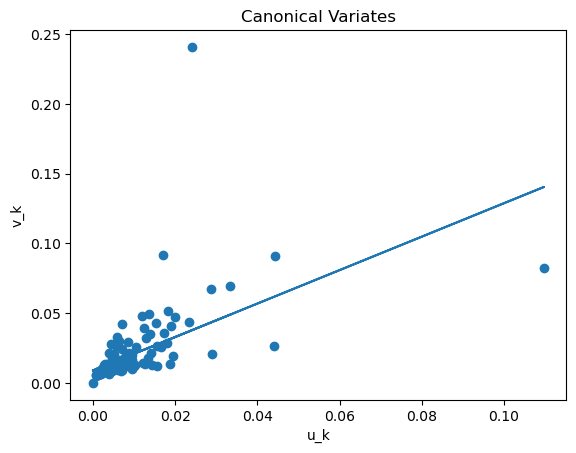

0.31546986430747315


In [11]:
# scatter plot of the canonical variates
plt.scatter(u_k, v_k)
# fit a line to the scatter plot
m, b = np.polyfit(u_k, v_k, 1)
plt.plot(u_k, m * u_k + b)
plt.xlabel("u_k")
plt.ylabel("v_k")
plt.title("Canonical Variates")
# add r2 of regression line to plot
plt.show()

# calculate r2 of k
from sklearn.metrics import r2_score

k_r2 = r2_score(v_k, m * u_k + b)
print(k_r2)

The variance of the canonical variates explained by the variables is 3.706506051761678 for X and 8.747748406503307 for Y


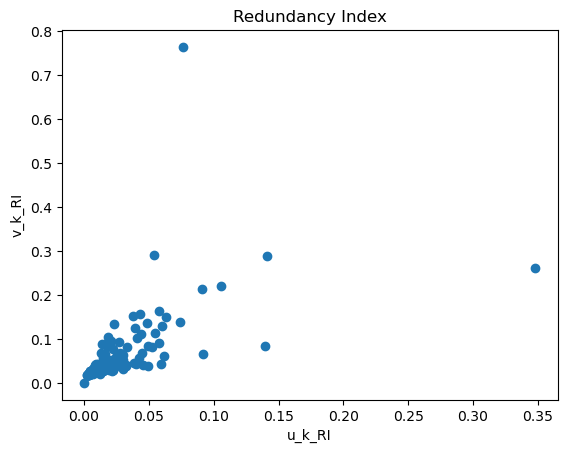

In [12]:
# calculate the redundancy index of each variable
u_k_RI = []
v_k_RI = []
for i in enumerate(u_k):
    # add to list
    u_k_RI.append(i[1] / k_r2)
for i in enumerate(v_k):
    # add to list
    v_k_RI.append(i[1] / k_r2)

sum_u_k_RI = sum(u_k_RI)
sum_v_k_RI = sum(v_k_RI)
print(
    f"The variance of the canonical variates explained by the variables is {sum_u_k_RI} for X and {sum_v_k_RI} for Y"
)

# plot the redundancy index
plt.scatter(u_k_RI, v_k_RI)
plt.xlabel("u_k_RI")
plt.ylabel("v_k_RI")
plt.title("Redundancy Index")
plt.show()

In [13]:
# df from the canonical variates
RI_df = pd.DataFrame([u_k_RI, v_k_RI], index=["u_k_RI", "v_k_RI"]).T
RI_df["Shuffle"] = Shuffle
# set output path
results_file_path_RI = pathlib.Path(f"../results/{cell_type}_redundancy_index.csv")
results_file_path_RI.parent.mkdir(parents=True, exist_ok=True)

if not results_file_path_RI.exists():
    RI_df.to_csv(results_file_path_RI, index=False)
elif results_file_path_RI.exists():
    # read in the existing file
    existing_df = pd.read_csv(results_file_path_RI)
    if len(existing_df["Shuffle"].unique()) > 1:
        # overwrite the file
        RI_df.to_csv(results_file_path_RI, index=False)
    elif existing_df["Shuffle"].unique() != Shuffle:
        # append to the file
        RI_df.to_csv(results_file_path_RI, mode="a", header=False, index=False)
    else:
        print("The file already exists and the shuffle value is the same")
        print("No write occured")
else:
    print("Something went wrong: check path for the redundancy index file")

In [14]:
out_dict = {}
for i in tqdm(range(2, K)):
    cca = CCA(n_components=i)
    cca.fit(morphology_data, nomic_data_values)
    X_c, Y_c = cca.transform(morphology_data, nomic_data_values)
    cca.score(morphology_data, nomic_data_values), X_c, Y_c
    coef_df = pd.DataFrame(
        cca.coef_, columns=morphology_data.columns, index=nomic_data_values.columns
    )
    # get the X and Y coefficients as np arrays
    X_coef = cca.x_weights_
    Y_coef = cca.y_weights_
    # get the variance explained by each canonical variate
    u_k = sum(cca.x_loadings_**2) / P
    v_k = sum(cca.y_loadings_**2) / Q
    k_r2 = r2_score(v_k, m * u_k + b)
    # calculate the redundancy index of each variable
    u_k_RI = []
    v_k_RI = []
    for i in enumerate(u_k):
        # add to list
        u_k_RI.append(i[1] / k_r2)
    for i in enumerate(v_k):
        # add to list
        v_k_RI.append(i[1] / k_r2)

    sum_u_k_RI = sum(u_k_RI)
    sum_v_k_RI = sum(v_k_RI)
    out_dict[i[0]] = [sum_u_k_RI, sum_v_k_RI, k_r2]

  0%|                                                                                                                                                      | 0/152 [00:00<?, ?it/s]

  1%|▉                                                                                                                                             | 1/152 [00:00<00:32,  4.62it/s]

  1%|█▊                                                                                                                                            | 2/152 [00:00<00:42,  3.56it/s]

  2%|██▊                                                                                                                                           | 3/152 [00:01<00:54,  2.74it/s]

  3%|███▋                                                                                                                                          | 4/152 [00:01<01:01,  2.39it/s]

  3%|████▋                                                                                                                                         | 5/152 [00:01<01:03,  2.32it/s]

  4%|█████▌                                                                                                                                        | 6/152 [00:02<01:05,  2.23it/s]

  5%|██████▌                                                                                                                                       | 7/152 [00:02<01:09,  2.10it/s]

  5%|███████▍                                                                                                                                      | 8/152 [00:03<01:14,  1.95it/s]

  6%|████████▍                                                                                                                                     | 9/152 [00:04<01:20,  1.79it/s]

  7%|█████████▎                                                                                                                                   | 10/152 [00:05<01:29,  1.59it/s]

  7%|██████████▏                                                                                                                                  | 11/152 [00:05<01:39,  1.42it/s]

  8%|███████████▏                                                                                                                                 | 12/152 [00:06<01:44,  1.33it/s]

  9%|████████████                                                                                                                                 | 13/152 [00:07<01:49,  1.27it/s]

  9%|████████████▉                                                                                                                                | 14/152 [00:08<01:54,  1.21it/s]

 10%|█████████████▉                                                                                                                               | 15/152 [00:09<02:01,  1.13it/s]

 11%|██████████████▊                                                                                                                              | 16/152 [00:10<02:08,  1.06it/s]

 11%|███████████████▊                                                                                                                             | 17/152 [00:11<02:15,  1.00s/it]

 12%|████████████████▋                                                                                                                            | 18/152 [00:12<02:19,  1.04s/it]

 12%|█████████████████▋                                                                                                                           | 19/152 [00:14<02:24,  1.09s/it]

 13%|██████████████████▌                                                                                                                          | 20/152 [00:15<02:28,  1.13s/it]

 14%|███████████████████▍                                                                                                                         | 21/152 [00:16<02:34,  1.18s/it]

 14%|████████████████████▍                                                                                                                        | 22/152 [00:17<02:40,  1.24s/it]

 15%|█████████████████████▎                                                                                                                       | 23/152 [00:19<02:48,  1.30s/it]

 16%|██████████████████████▎                                                                                                                      | 24/152 [00:20<02:55,  1.37s/it]

 16%|███████████████████████▏                                                                                                                     | 25/152 [00:22<03:01,  1.43s/it]

 17%|████████████████████████                                                                                                                     | 26/152 [00:24<03:22,  1.61s/it]

 18%|█████████████████████████                                                                                                                    | 27/152 [00:26<03:24,  1.64s/it]

 18%|█████████████████████████▉                                                                                                                   | 28/152 [00:27<03:17,  1.59s/it]

 19%|██████████████████████████▉                                                                                                                  | 29/152 [00:29<03:19,  1.62s/it]

 20%|███████████████████████████▊                                                                                                                 | 30/152 [00:31<03:22,  1.66s/it]

 20%|████████████████████████████▊                                                                                                                | 31/152 [00:33<03:46,  1.87s/it]

 21%|█████████████████████████████▋                                                                                                               | 32/152 [00:35<03:43,  1.87s/it]

 22%|██████████████████████████████▌                                                                                                              | 33/152 [00:37<03:48,  1.92s/it]

 22%|███████████████████████████████▌                                                                                                             | 34/152 [00:39<03:53,  1.98s/it]

 23%|████████████████████████████████▍                                                                                                            | 35/152 [00:41<03:54,  2.00s/it]

 24%|█████████████████████████████████▍                                                                                                           | 36/152 [00:43<03:50,  1.99s/it]

 24%|██████████████████████████████████▎                                                                                                          | 37/152 [00:45<03:51,  2.02s/it]

 25%|███████████████████████████████████▎                                                                                                         | 38/152 [00:47<03:50,  2.02s/it]

 26%|████████████████████████████████████▏                                                                                                        | 39/152 [00:50<03:59,  2.12s/it]

 26%|█████████████████████████████████████                                                                                                        | 40/152 [00:52<04:18,  2.31s/it]

 27%|██████████████████████████████████████                                                                                                       | 41/152 [00:55<04:15,  2.31s/it]

 28%|██████████████████████████████████████▉                                                                                                      | 42/152 [00:57<04:10,  2.28s/it]

 28%|███████████████████████████████████████▉                                                                                                     | 43/152 [00:59<04:10,  2.30s/it]

 29%|████████████████████████████████████████▊                                                                                                    | 44/152 [01:02<04:11,  2.33s/it]

 30%|█████████████████████████████████████████▋                                                                                                   | 45/152 [01:05<04:35,  2.58s/it]

 30%|██████████████████████████████████████████▋                                                                                                  | 46/152 [01:07<04:37,  2.62s/it]

 31%|███████████████████████████████████████████▌                                                                                                 | 47/152 [01:10<04:33,  2.60s/it]

 32%|████████████████████████████████████████████▌                                                                                                | 48/152 [01:13<04:28,  2.58s/it]

 32%|█████████████████████████████████████████████▍                                                                                               | 49/152 [01:15<04:26,  2.58s/it]

 33%|██████████████████████████████████████████████▍                                                                                              | 50/152 [01:18<04:22,  2.57s/it]

 34%|███████████████████████████████████████████████▎                                                                                             | 51/152 [01:20<04:26,  2.64s/it]

 34%|████████████████████████████████████████████████▏                                                                                            | 52/152 [01:23<04:31,  2.72s/it]

 35%|█████████████████████████████████████████████████▏                                                                                           | 53/152 [01:27<04:47,  2.90s/it]

 36%|██████████████████████████████████████████████████                                                                                           | 54/152 [01:30<04:45,  2.91s/it]

 36%|███████████████████████████████████████████████████                                                                                          | 55/152 [01:33<04:43,  2.92s/it]

 37%|███████████████████████████████████████████████████▉                                                                                         | 56/152 [01:36<04:51,  3.04s/it]

 38%|████████████████████████████████████████████████████▉                                                                                        | 57/152 [01:39<05:00,  3.16s/it]

 38%|█████████████████████████████████████████████████████▊                                                                                       | 58/152 [01:43<05:15,  3.35s/it]

 39%|██████████████████████████████████████████████████████▋                                                                                      | 59/152 [01:46<05:08,  3.32s/it]

 39%|███████████████████████████████████████████████████████▋                                                                                     | 60/152 [01:49<04:57,  3.24s/it]

 40%|████████████████████████████████████████████████████████▌                                                                                    | 61/152 [01:53<04:50,  3.19s/it]

 41%|█████████████████████████████████████████████████████████▌                                                                                   | 62/152 [01:56<04:50,  3.23s/it]

 41%|██████████████████████████████████████████████████████████▍                                                                                  | 63/152 [02:00<05:00,  3.37s/it]

 42%|███████████████████████████████████████████████████████████▎                                                                                 | 64/152 [02:03<05:00,  3.42s/it]

 43%|████████████████████████████████████████████████████████████▎                                                                                | 65/152 [02:07<05:21,  3.69s/it]

 43%|█████████████████████████████████████████████████████████████▏                                                                               | 66/152 [02:12<05:29,  3.83s/it]

 44%|██████████████████████████████████████████████████████████████▏                                                                              | 67/152 [02:16<05:28,  3.87s/it]

 45%|███████████████████████████████████████████████████████████████                                                                              | 68/152 [02:19<05:15,  3.76s/it]

 45%|████████████████████████████████████████████████████████████████                                                                             | 69/152 [02:23<05:16,  3.82s/it]

 46%|████████████████████████████████████████████████████████████████▉                                                                            | 70/152 [02:27<05:15,  3.85s/it]

 47%|█████████████████████████████████████████████████████████████████▊                                                                           | 71/152 [02:31<05:17,  3.92s/it]

 47%|██████████████████████████████████████████████████████████████████▊                                                                          | 72/152 [02:35<05:10,  3.88s/it]

 48%|███████████████████████████████████████████████████████████████████▋                                                                         | 73/152 [02:39<05:07,  3.89s/it]

 49%|████████████████████████████████████████████████████████████████████▋                                                                        | 74/152 [02:43<05:03,  3.89s/it]

 49%|█████████████████████████████████████████████████████████████████████▌                                                                       | 75/152 [02:47<05:02,  3.92s/it]

 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 76/152 [02:50<04:58,  3.93s/it]

 51%|███████████████████████████████████████████████████████████████████████▍                                                                     | 77/152 [02:55<04:56,  3.95s/it]

 51%|████████████████████████████████████████████████████████████████████████▎                                                                    | 78/152 [02:58<04:49,  3.91s/it]

 52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 79/152 [03:03<04:52,  4.01s/it]

 53%|██████████████████████████████████████████████████████████████████████████▏                                                                  | 80/152 [03:07<04:56,  4.12s/it]

 53%|███████████████████████████████████████████████████████████████████████████▏                                                                 | 81/152 [03:11<04:56,  4.17s/it]

 54%|████████████████████████████████████████████████████████████████████████████                                                                 | 82/152 [03:15<04:53,  4.20s/it]

 55%|████████████████████████████████████████████████████████████████████████████▉                                                                | 83/152 [03:20<04:53,  4.26s/it]

 55%|█████████████████████████████████████████████████████████████████████████████▉                                                               | 84/152 [03:25<04:58,  4.39s/it]

 56%|██████████████████████████████████████████████████████████████████████████████▊                                                              | 85/152 [03:29<04:59,  4.47s/it]

 57%|███████████████████████████████████████████████████████████████████████████████▊                                                             | 86/152 [03:34<04:59,  4.53s/it]

 57%|████████████████████████████████████████████████████████████████████████████████▋                                                            | 87/152 [03:38<04:51,  4.49s/it]

 58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 88/152 [03:43<04:50,  4.54s/it]

 59%|██████████████████████████████████████████████████████████████████████████████████▌                                                          | 89/152 [03:48<04:50,  4.61s/it]

 59%|███████████████████████████████████████████████████████████████████████████████████▍                                                         | 90/152 [03:52<04:46,  4.62s/it]

 60%|████████████████████████████████████████████████████████████████████████████████████▍                                                        | 91/152 [03:58<04:59,  4.90s/it]

 61%|█████████████████████████████████████████████████████████████████████████████████████▎                                                       | 92/152 [04:03<04:54,  4.92s/it]

 61%|██████████████████████████████████████████████████████████████████████████████████████▎                                                      | 93/152 [04:08<05:00,  5.10s/it]

 62%|███████████████████████████████████████████████████████████████████████████████████████▏                                                     | 94/152 [04:13<04:53,  5.06s/it]

 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 95/152 [04:18<04:44,  5.00s/it]

 63%|█████████████████████████████████████████████████████████████████████████████████████████                                                    | 96/152 [04:23<04:39,  4.99s/it]

 64%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 97/152 [04:28<04:31,  4.94s/it]

 64%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 98/152 [04:33<04:32,  5.05s/it]

 65%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 99/152 [04:38<04:22,  4.96s/it]

 66%|████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/152 [04:43<04:23,  5.07s/it]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████                                               | 101/152 [04:49<04:21,  5.12s/it]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/152 [04:54<04:14,  5.10s/it]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 103/152 [04:59<04:15,  5.22s/it]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/152 [05:05<04:13,  5.29s/it]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 105/152 [05:10<04:15,  5.44s/it]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 106/152 [05:17<04:22,  5.70s/it]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 107/152 [05:25<04:55,  6.57s/it]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 108/152 [05:31<04:37,  6.31s/it]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 109/152 [05:37<04:24,  6.15s/it]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 110/152 [05:43<04:15,  6.08s/it]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 111/152 [05:49<04:08,  6.07s/it]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 112/152 [05:55<03:59,  5.99s/it]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 113/152 [06:00<03:49,  5.88s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 114/152 [06:06<03:38,  5.76s/it]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 115/152 [06:11<03:29,  5.67s/it]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 116/152 [06:17<03:25,  5.70s/it]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 117/152 [06:23<03:22,  5.78s/it]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 118/152 [06:30<03:26,  6.07s/it]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 119/152 [06:36<03:25,  6.23s/it]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 120/152 [06:42<03:18,  6.21s/it]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 121/152 [06:49<03:12,  6.21s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 122/152 [06:55<03:07,  6.25s/it]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 123/152 [07:02<03:03,  6.34s/it]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 124/152 [07:08<02:59,  6.41s/it]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 125/152 [07:15<02:56,  6.54s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 126/152 [07:22<02:51,  6.60s/it]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 127/152 [07:29<02:47,  6.70s/it]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 128/152 [07:35<02:41,  6.71s/it]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 129/152 [07:42<02:33,  6.67s/it]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 130/152 [07:49<02:27,  6.73s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 131/152 [07:56<02:23,  6.82s/it]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 132/152 [08:03<02:17,  6.88s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 133/152 [08:10<02:11,  6.94s/it]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 134/152 [08:17<02:04,  6.93s/it]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 135/152 [08:24<01:58,  6.94s/it]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 136/152 [08:31<01:52,  7.04s/it]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 137/152 [08:38<01:46,  7.07s/it]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 138/152 [08:45<01:38,  7.04s/it]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 139/152 [08:53<01:32,  7.14s/it]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 140/152 [09:00<01:25,  7.16s/it]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 141/152 [09:07<01:18,  7.12s/it]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 142/152 [09:14<01:10,  7.03s/it]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 143/152 [09:21<01:05,  7.24s/it]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 144/152 [09:30<01:00,  7.52s/it]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 145/152 [09:37<00:52,  7.43s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 146/152 [09:44<00:44,  7.35s/it]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 147/152 [09:51<00:36,  7.35s/it]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 148/152 [09:59<00:29,  7.36s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 149/152 [10:07<00:22,  7.54s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 150/152 [10:15<00:15,  7.68s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 151/152 [10:23<00:07,  7.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [10:32<00:00,  8.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [10:32<00:00,  4.16s/it]

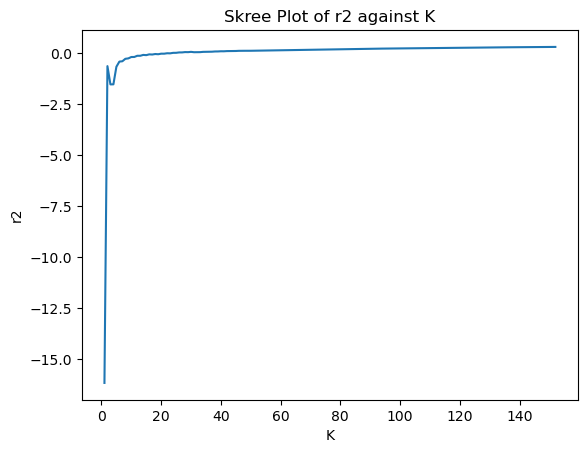

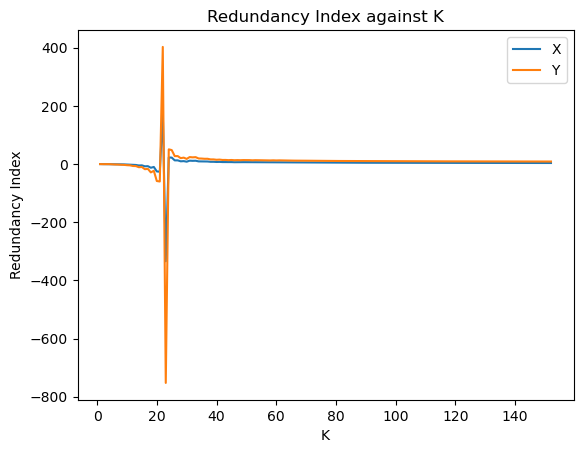

In [15]:
# dict to df
out_df = pd.DataFrame.from_dict(
    out_dict, orient="index", columns=["X_RI", "Y_RI", "r2"]
)
# reset index
out_df = out_df.reset_index()
# rename index column
out_df = out_df.rename(columns={"index": "K"})
out_df["Shuffle"] = Shuffle
# plot the redundancy index
plt.plot(out_df["K"], out_df["r2"], label="X")
plt.xlabel("K")
plt.ylabel("r2")
plt.title("Skree Plot of r2 against K")
plt.show()

# plot the redundancy index
plt.plot(out_df["K"], out_df["X_RI"], label="X")
plt.plot(out_df["K"], out_df["Y_RI"], label="Y")
plt.xlabel("K")
plt.ylabel("Redundancy Index")
plt.title("Redundancy Index against K")
plt.legend()
plt.show()

In [16]:
# check if file exists
if not results_file_path.exists():
    # write to file
    out_df.to_csv(results_file_path, index=False)
    pass
elif results_file_path.exists():
    # read in the file
    old_df = pd.read_csv(results_file_path)
    if len(old_df["Shuffle"] > 1):
        # overwrite the file
        out_df.to_csv(results_file_path, index=False)
elif results_file_path.exists():
    # read in the file
    old_df = pd.read_csv(results_file_path)
    if old_df["Shuffle"].unique() == Shuffle:
        pass
    else:
        # concat the dfs and write to file
        out_df = pd.concat([old_df, out_df])
        out_df.to_csv(results_file_path, index=False)